# Initializations

In [619]:
import numpy as np
import pandas as pd

import sys, os, time
import glob

from matplotlib import pyplot as plt
%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.utils as vutils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Set some variables used throughout

In [90]:
dataroot = "/home/data/world-cities/"

nz   = 100
ngf  = 16
ndf  = 16
nc   = 1
imageSize = 64
batchSize = 64
workers   = 4

# Plot fake and real samples

In [582]:
experiment_root = "/home/data/pytorch-workspace/DCGAN/"

experiment_dir = experiment_root + "16-weak-cond-2pct-6" # "16-weak-cond-2pct-5/" 


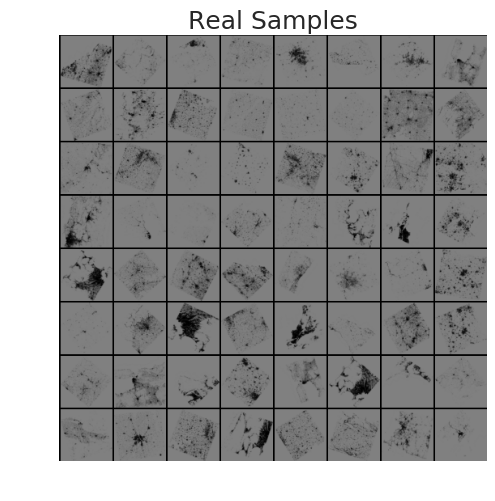

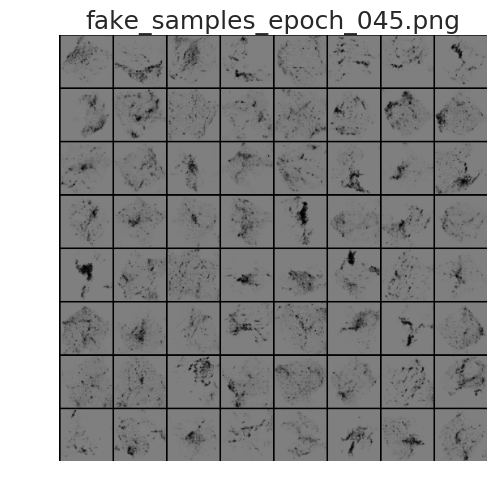

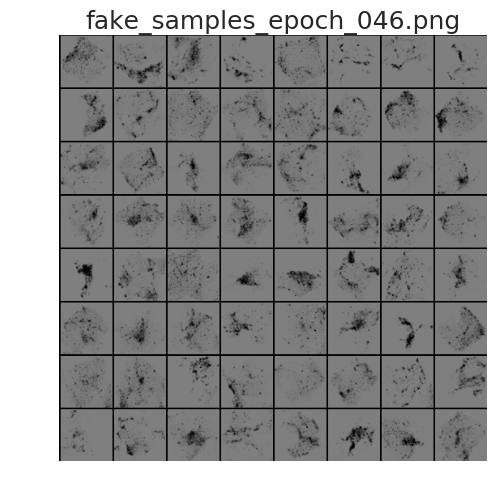

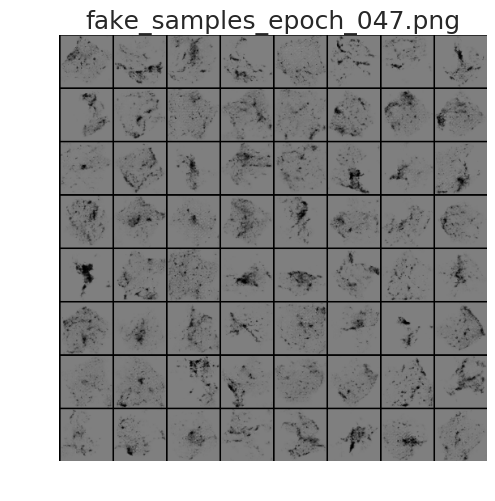

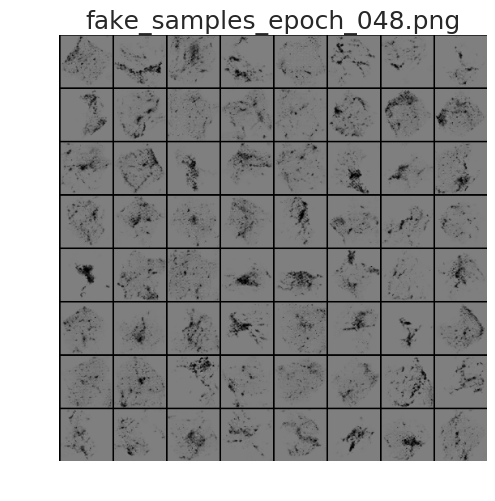

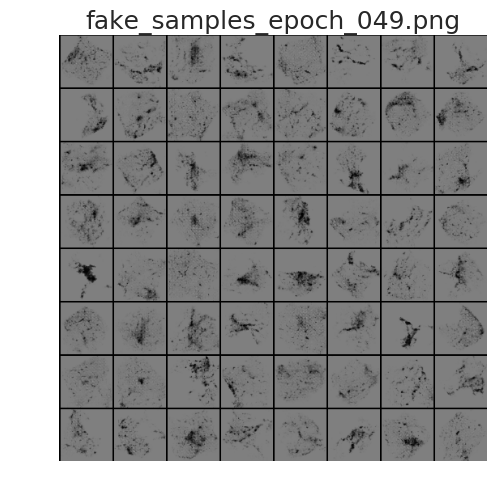

In [598]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

files_fake = glob.glob(experiment_dir + "/fake*.png")
files_fake.sort(key=lambda x: int(os.path.basename(x).split("_")[-1].replace(".png","")))

files_real = glob.glob(experiment_dir + "/real*.png")

img_real = imread(files_real[0])
img_real = img_real / float(img_real.max())
plt.imshow(1-np.abs(img_real))
plt.title("Real Samples")
plt.axis("off")
plt.show()

for f in files_fake[-5:]:
    img = imread(f)
    img = img / float(img.max())
    plt.imshow(1 - np.abs(img))
    plt.title(os.path.basename(f))
    plt.axis("off")
    plt.show()


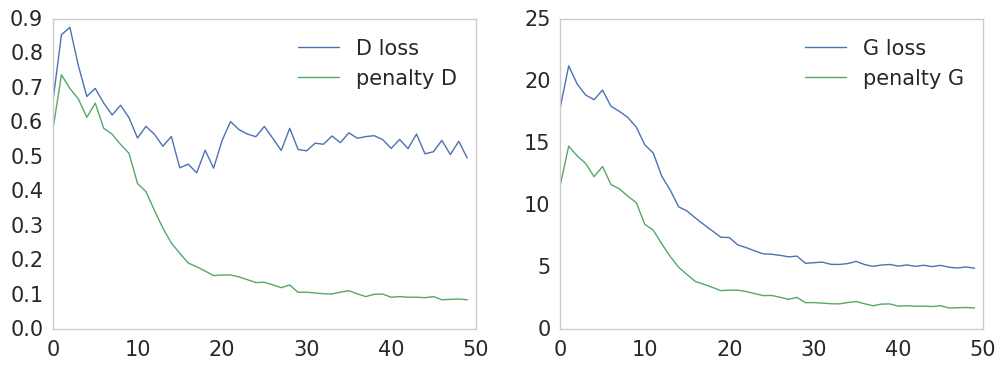

In [597]:
import cPickle as pickle
import gzip

with gzip.open(experiment_dir + "/training-loss.pickle.gz", "r") as f:
    lossD, lossG, lossED, lossEG = pickle.load(f)
    # lossD, lossG, lossE = pickle.load(f)
    
lossD = np.array(lossD)
lossG = np.array(lossG)
lossED = np.array(lossED)
lossEG = np.array(lossEG)

# plot
fig,ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(lossD[:,0], label="D loss")
ax[0].plot(lossED[:,0], label="penalty D")
ax[0].legend()
ax[1].plot(lossG[:,0], label="G loss")
ax[1].plot(lossEG[:,0], label="penalty G")
ax[1].legend()

# Validate generator

#### Load last checkpointed generator model

In [599]:
files_cptG = glob.glob(experiment_dir + "/netG*.pth")
files_cptG = {int(os.path.basename(f).split(".")[0].split("_")[-1]):f \
              for f in files_cptG}
netG_ckpt = files_cptG[np.argmax(files_cptG.keys())]
print netG_ckpt

/home/data/pytorch-workspace/DCGAN/16-weak-cond-2pct-6/netG_epoch_49.pth


In [600]:
sys.path.append("../models/")
import models.dcgan_orig as do

ngpu = 2
ncond= 1
netG = do._netG(ngpu, nc, nz + ncond, ngf)

netG.load_state_dict(torch.load(netG_ckpt))
# if torch.cuda.is_available():
#     netG.cuda()

#### Generate synthetic samples and compare statistics

In [601]:
def generate_samples(Z, cond=None, cuda=False):
    N, nz = Z.shape
    Zv = torch.FloatTensor(Z.reshape(N, nz, 1, 1))
    if cuda:
        Zv = Zv.cuda()
    if cond is not None:
        ncond = cond.shape[1]
        cond = torch.from_numpy(cond).float()
        if cuda:
            cond = cond.cuda()
        cond = Variable(cond)
        cond.data.resize_(N, ncond, 1, 1)
    Zv = Variable(Zv)
    fake = netG(Zv, cond=cond)
    return fake

In [602]:
def compute_stats(batch):
    return batch.abs().mean(2).mean(3)

0.0518407
0.832727022144 0.00114566690225


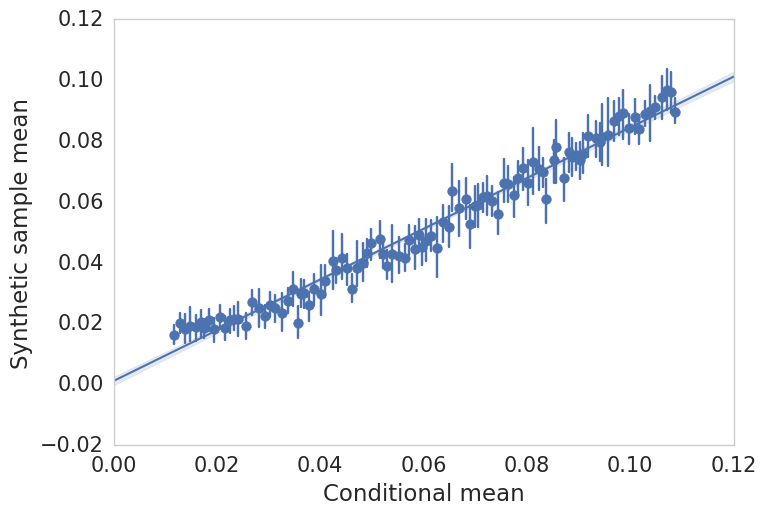

In [618]:
N = 1000

Z = np.random.randn(N, nz)
cond = 0.01 + np.random.rand(N,1) * 0.1

fake = generate_samples(Z, cond=cond)

stats_fake = compute_stats(fake)
stats_fake_np = stats_fake.data.numpy().squeeze()
print stats_fake_np.mean()

# compute correlation coefficient
from scipy import polyfit
(ar,br)=polyfit(cond[:,0],stats_fake_np,1)
print ar, br

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})

tips = sns.load_dataset("tips")
ax = sns.regplot(x=cond, y=stats_fake_np, x_bins=100)
ax.set_xlabel("Conditional mean")
ax.set_ylabel("Synthetic sample mean")

# Explore latent space 
 - a way to assess representation quality introduced in the DCGAN paper

0.0523676


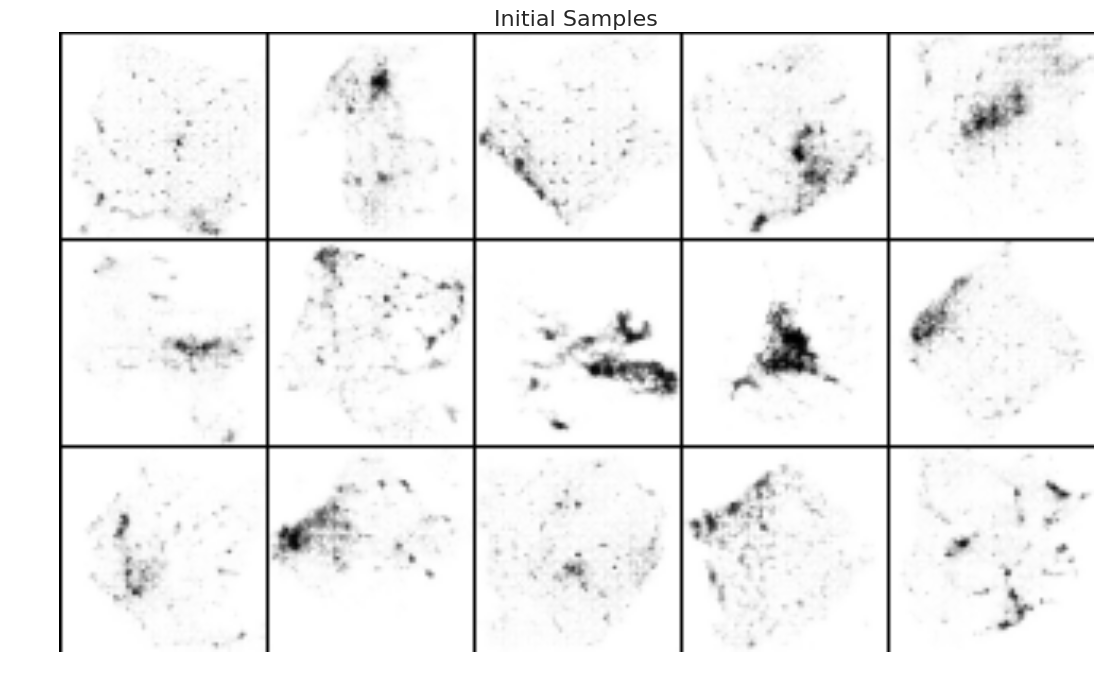

In [612]:
N = 100

Z = np.random.randn(N, nz)
cond = np.ones((N,1)) * 0.08

fake = generate_samples(Z, cond=cond)

stats_fake = compute_stats(fake)
stats_fake_np = stats_fake.data.numpy().squeeze()
print stats_fake_np.mean()

canvas = vutils.make_grid(fake.data[:15], nrow=5, padding=1).numpy()

plt.figure(figsize=(16,8))
plt.imshow(np.abs(canvas[0,:,:]))
plt.axis("off")
plt.title("Initial Samples", fontsize=16)

(array([  2.,   5.,   5.,   2.,   7.,   4.,   8.,   6.,   8.,   9.,  10.,
          7.,   6.,   3.,   8.,   5.,   2.,   0.,   2.,   1.]),
 array([ 0.03081282,  0.03313528,  0.03545774,  0.0377802 ,  0.04010266,
         0.04242512,  0.04474757,  0.04707003,  0.04939249,  0.05171495,
         0.05403741,  0.05635987,  0.05868232,  0.06100478,  0.06332724,
         0.0656497 ,  0.06797216,  0.07029462,  0.07261708,  0.07493953,
         0.07726199]),
 <a list of 20 Patch objects>)

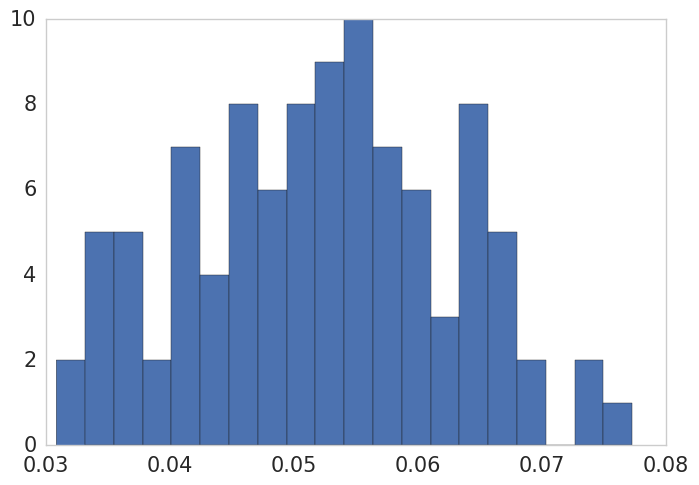

In [607]:
plt.hist(stats_fake_np, bins=20)

#### Generate interpolation map

In [541]:
def generate_interpolation_map(Z,M):
    N, nz = Z.shape
    Z_map = np.zeros((N-1,M+1,nz))
    for n in range(N-1):
        dZ = (Z[n+1,:] - Z[n,:]) / float(M)
        for m in range(M+1):
            Z_map[n,m,:] = Z[n,:] + m*dZ
    Z_map = Z_map.reshape(((N-1)*(M+1), nz))
    return Z_map

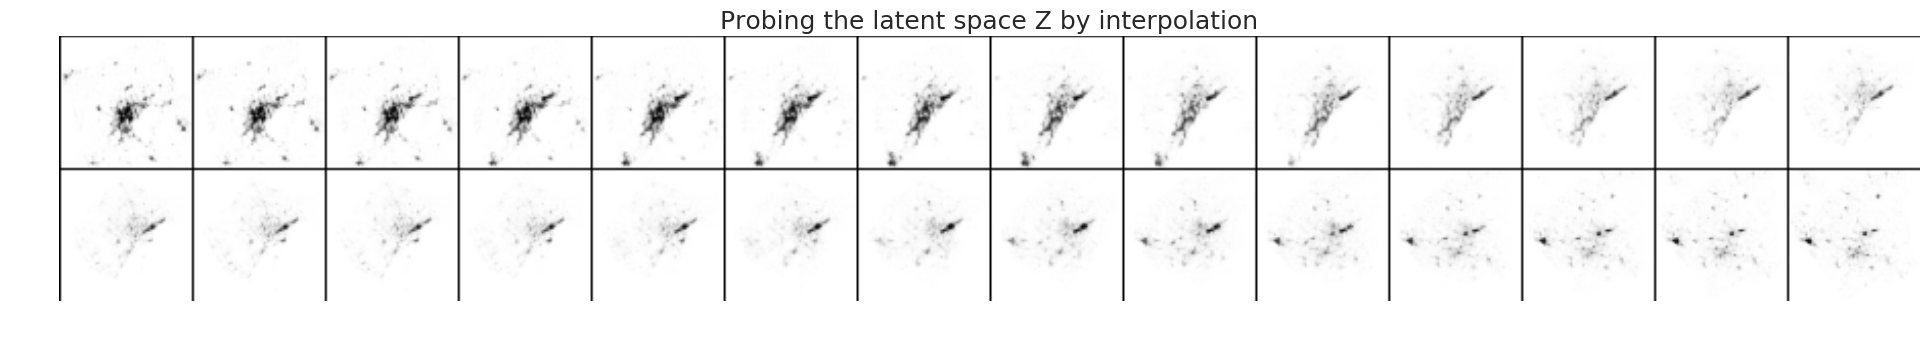

In [543]:
M = 15

Z_map = generate_interpolation_map(Z[[0,3,12]], M)
fake = generate_samples(Z_map, cond=cond)

canvas = vutils.make_grid(fake.data, nrow=M-1, padding=1).numpy()

plt.figure(figsize=(24,10))
plt.imshow(np.abs(canvas[0,:,:]))
plt.axis("off")
plt.title("Probing the latent space Z by interpolation")

# Morph between real samples

In [621]:
import torch.optim as optim

In [643]:
ngpu = 2
ncond= 1
netG = do._netG(ngpu, nc, nz + ncond, ngf)

netG.load_state_dict(torch.load(netG_ckpt))

In [656]:
from skimage.transform import resize 

def read_img(f, imgSize=None):
    img = imread(f)
    img[img==128] = 0 # this removes gray patches that indicate no data/water bodies
    if imgSize is not None:
        img = resize(img, (imgSize, imgSize), preserve_range=True)
    return img

In [715]:
mycities = ["paris, fr", "moscow, ru", "lagos, ng", "san francisco, us", "new delhi, in", "boston, us"]

image_dict = {}
for c in mycities:
    f = test_df[test_df.city.str.contains(c)]['filename'].iloc[0]
    image_dict[c] = read_img(f, 64)
    
img_batch = np.expand_dims(np.array(image_dict.values()), 1)

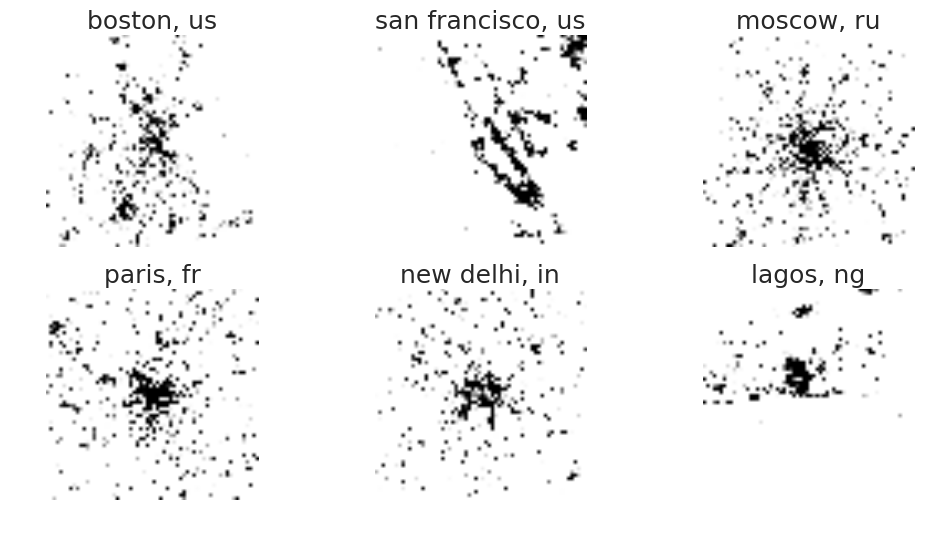

In [709]:
fig, ax = plt.subplots(2,3, figsize=(12,6))
for k, (c, img) in enumerate(image_dict.iteritems()):
    i = k / 3
    j = k % 3
    ax[i,j].imshow(img)
    ax[i,j].axis("off")
    ax[i,j].set_title(c)

In [798]:
crit_l1 = nn.L1Loss()
netG = netG.cuda()

def compute_latent_representation(img_batch, niter=5000, lr=0.02):
    batch_size, nc, imgSize, _ = img_batch.shape
    Zv = torch.rand(batch_size, nz+1, 1, 1).type(torch.FloatTensor)
    Zv[:,-1,:,:] = 0.05
    Zv = Zv.cuda()
    Zv = Variable(Zv, requires_grad=True)
    imgv = torch.FloatTensor(img_batch)
    imgv = imgv.cuda()
    imgv = Variable(imgv, requires_grad=False)

    # optimizer = optim.Adam(iter(Zv), lr=lr, betas=(0.5, 0.999))

    # make sure generator parameters are fixed
    for param in netG.parameters():
        param.requires_grad = False

    loss_hist = []
    for i in range(niter):
        # Forward + Backward + Optimize
        fake = netG(Zv)
        loss = crit_l1(fake.abs(), imgv)

        loss.backward()
    #     optimizer.zero_grad()
    #     optimizer.step()

        Zv.data -= lr * Zv.grad.data # rather hackish, how to use optimizer (Adam) for this?
        Zv.grad.data.zero_()

        loss_hist.append(loss.data[0])
        if i % 1000 == 0:
            print '[%d/%d] Loss: %.4f' % (i, niter, loss.data[0])
    
    return Zv, loss_hist

In [802]:
img = image_dict['lagos, ng']
img = img / 255.0
img1 = np.expand_dims(np.expand_dims(img,0),0)

Zv, loss_hist = compute_latent_representation(img1, niter=20000, lr=1.0)
Z_np = Zv.data.cpu().numpy().squeeze()

[0/20000] Loss: 0.0928
[1000/20000] Loss: 0.0466
[2000/20000] Loss: 0.0443
[3000/20000] Loss: 0.0433
[4000/20000] Loss: 0.0427
[5000/20000] Loss: 0.0422
[6000/20000] Loss: 0.0418
[7000/20000] Loss: 0.0416
[8000/20000] Loss: 0.0414
[9000/20000] Loss: 0.0413
[10000/20000] Loss: 0.0410
[11000/20000] Loss: 0.0407
[12000/20000] Loss: 0.0405
[13000/20000] Loss: 0.0403
[14000/20000] Loss: 0.0403
[15000/20000] Loss: 0.0402
[16000/20000] Loss: 0.0402
[17000/20000] Loss: 0.0402
[18000/20000] Loss: 0.0401
[19000/20000] Loss: 0.0401


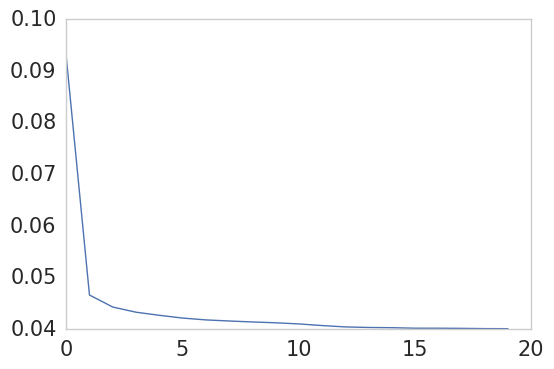

In [803]:
plt.plot(loss_hist[:-1:1000])

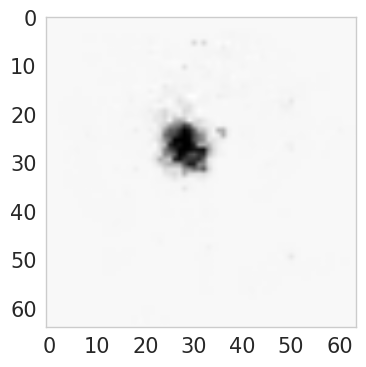

In [804]:
fake = netG(Zv)
img_rec = fake.data.cpu().numpy().squeeze()
plt.imshow(img_rec)

In [761]:
Z_mycities = []
for c, img in image_dict.iteritems():
    print c
    img1 = np.expand_dims(np.expand_dims(img,0),0)
    Zv, loss_hist = compute_latent_representation(img1)
    Z_np = Zv.data.cpu().numpy().squeeze()
    Z_mycities.append(Z_np)

boston, us
[0/5000] Loss: 19.8817
[1000/5000] Loss: 19.8650
[2000/5000] Loss: 19.8623
[3000/5000] Loss: 19.8610
[4000/5000] Loss: 19.8603
san francisco, us
[0/5000] Loss: 21.7947
[1000/5000] Loss: 21.7712
[2000/5000] Loss: 21.7684
[3000/5000] Loss: 21.7665
[4000/5000] Loss: 21.7653
moscow, ru
[0/5000] Loss: 25.1017
[1000/5000] Loss: 25.0619
[2000/5000] Loss: 25.0590
[3000/5000] Loss: 25.0587
[4000/5000] Loss: 25.0582
paris, fr
[0/5000] Loss: 23.6146
[1000/5000] Loss: 23.5746
[2000/5000] Loss: 23.5714
[3000/5000] Loss: 23.5704
[4000/5000] Loss: 23.5696
new delhi, in
[0/5000] Loss: 17.8887
[1000/5000] Loss: 17.8427
[2000/5000] Loss: 17.8409
[3000/5000] Loss: 17.8402
[4000/5000] Loss: 17.8397
lagos, ng
[0/5000] Loss: 11.2680
[1000/5000] Loss: 11.2358
[2000/5000] Loss: 11.2345
[3000/5000] Loss: 11.2336
[4000/5000] Loss: 11.2332


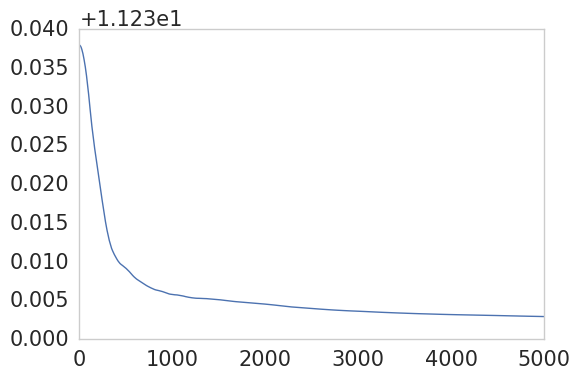

In [762]:
plt.plot(loss_hist)

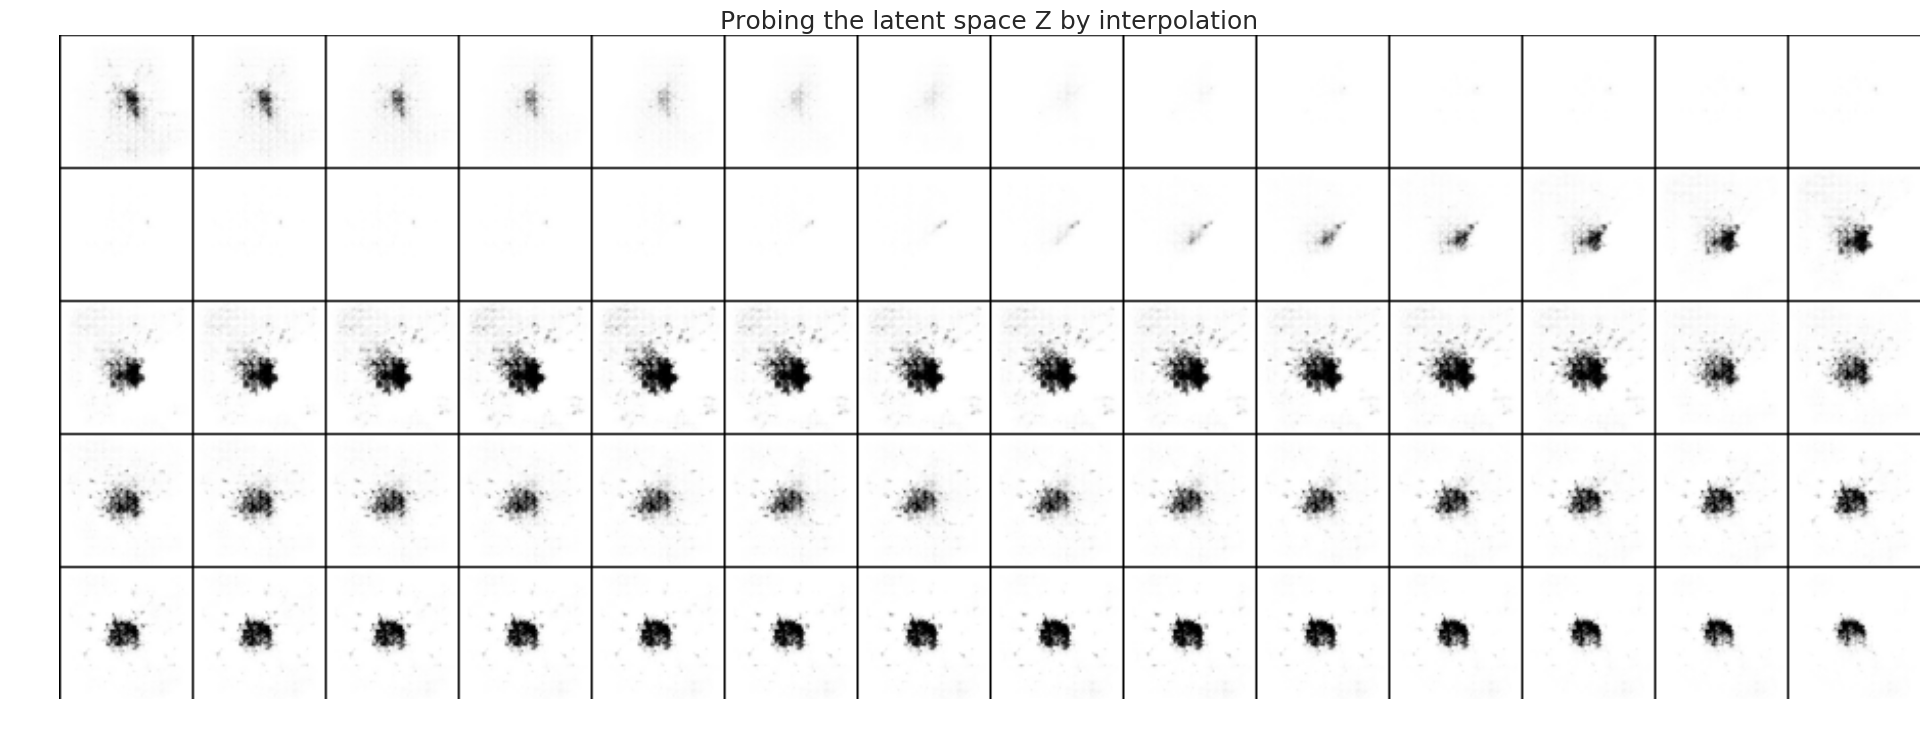

In [763]:
M = 15

Z_map = generate_interpolation_map(np.array(Z_mycities), M)
fake = generate_samples(Z_map, cuda=True)

canvas = vutils.make_grid(fake.data.cpu(), nrow=M-1, padding=1).numpy()

plt.figure(figsize=(24,10))
plt.imshow(np.abs(canvas[0,:,:]))
plt.axis("off")
plt.title("Probing the latent space Z by interpolation")

# Extract features for test samples

#### Load discriminator

In [30]:
# get checkpoints

files_cptD = glob.glob(experiment_dir + "/netD*.pth")
files_cptD = {int(os.path.basename(f).split(".")[0].split("_")[-1]):f \
              for f in files_cptD}

last_checkpoint = files_cptD[np.argmax(files_cptD.keys())]

In [31]:
sys.path.append("../models/")
import models.dcgan_orig as do

ngpu = 2
netD = do._netD(ngpu, nc, ndf)

netD.load_state_dict(torch.load(last_checkpoint))
if torch.cuda.is_available():
    netD.cuda()

feature_extractor = nn.Sequential(*list(list(netD.children())[0].children())[:-2])

#### Set up test data sources

In [35]:
sys.path.append("./../models/pytorch_utils")
from loader_dataframe import ImageDataFrame, grayscale_loader
import torchvision.transforms as transforms

test_df = pd.read_csv(dataroot + "/test.csv")

dataset = ImageDataFrame(df=test_df, classCol='city',
                         loader=grayscale_loader,
                         transform=transforms.Compose([
                               transforms.Scale(imageSize),
                               transforms.CenterCrop(imageSize),
                               transforms.ToTensor(),
                               # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

assert dataset

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize,
                                     shuffle=False, num_workers=int(workers))


#### Extract features from discriminator

In [36]:
from torch.autograd import Variable

def extract_features(feature_extractor, X):
    '''
    X is a list of data batches or a generator (dataloader).
    '''
    input = torch.FloatTensor(batchSize, nc, imageSize, imageSize)
    if torch.cuda.is_available():
        input = input.cuda()
    input = Variable(input)

    labels = []
    features = []
    for i, data in enumerate(X):
        feature_extractor.zero_grad()
        real_cpu, lab_batch = data
        batch_size = real_cpu.size(0)
        input.data.resize_(real_cpu.size()).copy_(real_cpu)
        feat_batch = feature_extractor(input)
        feat_batch = feat_batch.data.cpu().numpy().reshape((batch_size,-1))

        features.append(feat_batch)
        if lab_batch is not None:
            lab_batch = lab_batch.numpy()
        labels.append(lab_batch)

    features = np.vstack(features)
    labels = np.hstack(labels)
    
    return features, labels

In [37]:
features, labels = extract_features(feature_extractor, dataloader)

In [ ]:
# import cPickle as pickle
# import gzip

# with gzip.open("test_set_features.pickle.gz", "r") as f:
#     features = pickle.load(f)

In [ ]:
import cPickle as pickle
import gzip

with gzip.open("test_set_features.pickle.gz", "w") as f:
    pickle.dump(features, f)

# Generate lots of synthetic samples
- pass them through the Discriminator to obtain features

In [38]:
N = 100000
Z = np.random.randn(N, nz)

fake = generate_samples(Z, cuda=False)
# img_fake = fake.data.numpy().squeeze()

n_batches = int(np.ceil(float(N)/batchSize))
fake_batches = [(fake.data[(i*batchSize):min([N,((i+1)*batchSize)])], None) \
                for i in range(n_batches)]

In [39]:
img_fake = fake.data.numpy().squeeze()
img_fake = 1 - np.abs(img_fake)

In [40]:
features_fake, labels_fake = extract_features(feature_extractor, fake_batches)

features_fake.shape

(100000, 2048)

In [41]:
p_fake = pd.Series([img.mean() for img in img_fake])

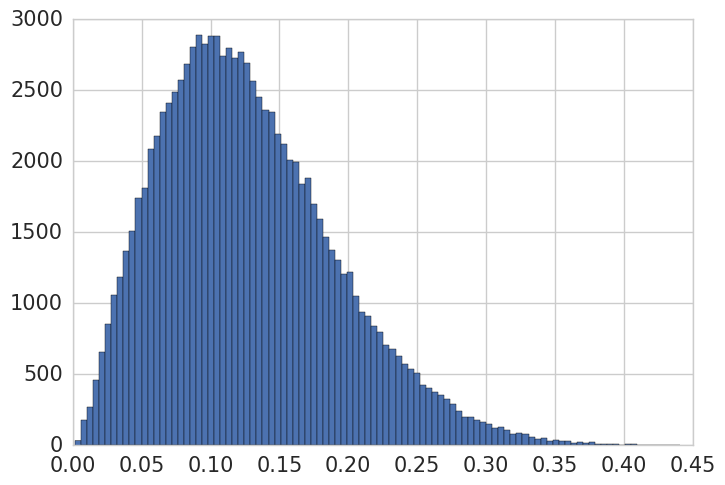

In [42]:
p_fake[p_fake<0.45].hist(bins=100)

In [ ]:
large_fake_img = img_fake[(p_fake >= 0.14) & (p_fake <= 0.15)]
print len(large_fake_img)

In [ ]:
for img in large_fake_img[:20]:
    plt.imshow(img)
    plt.show()

# Project to low-d embedding space via t-SNE

In [ ]:
from sklearn import decomposition
N_PCA = 50

pca = decomposition.PCA(n_components=N_PCA)

feats_pca = pca.fit_transform(features)[:,:N_PCA]

plt.figure(figsize=(4,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("PCA Components Variance Explained")
plt.xlabel("# components")
plt.ylabel("% variance")

In [ ]:
# https://github.com/DmitryUlyanov/Multicore-TSNE

from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=32, perplexity=30, n_components=20)
feats_tsne = tsne.fit_transform(features.astype(np.float64))

In [ ]:
feats_tsne.shape

# Similar image search: real cities

In [45]:
from scipy.spatial import cKDTree
from sklearn.neighbors import KDTree, BallTree

myfeatures = features # feats_tsne

tree = BallTree(myfeatures, leaf_size=100)

In [65]:
# mycities = ["barcelona, es", "athens, gr", "berlin, de", 
#             "hyderabad, in",
#             "boston, us", "san francisco, us"]
mycities = ["san francisco, us", "paris, fr", "delhi, in"]
sel_df = test_df[test_df['city'].apply(lambda s: sum([x in s for x in mycities])>0)]

feats_sel = myfeatures[sel_df.index,:]

n_examples = 4
_, neighbors = tree.query(feats_sel, k=n_examples, dualtree=True)

In [66]:
from skimage.io import imread, imsave
from skimage.transform import resize

# create canvass
canvass = []
for city0,f0,idx in zip(sel_df['city'], sel_df['filename'], neighbors):
    img0 = imread(f0)
    # imsave(experiment_dir + "./example_%s"%city0, img0)
    row = [np.pad(resize(img0, (100,100)), (2,2), "constant")]
    for _,r in test_df.ix[idx[1:]].iterrows():
        img = imread(r['filename'])
        row.append(np.pad(resize(img, (100,100)), (2,2), "constant"))
    canvass.append(np.hstack(row))
canvass = np.vstack(canvass)

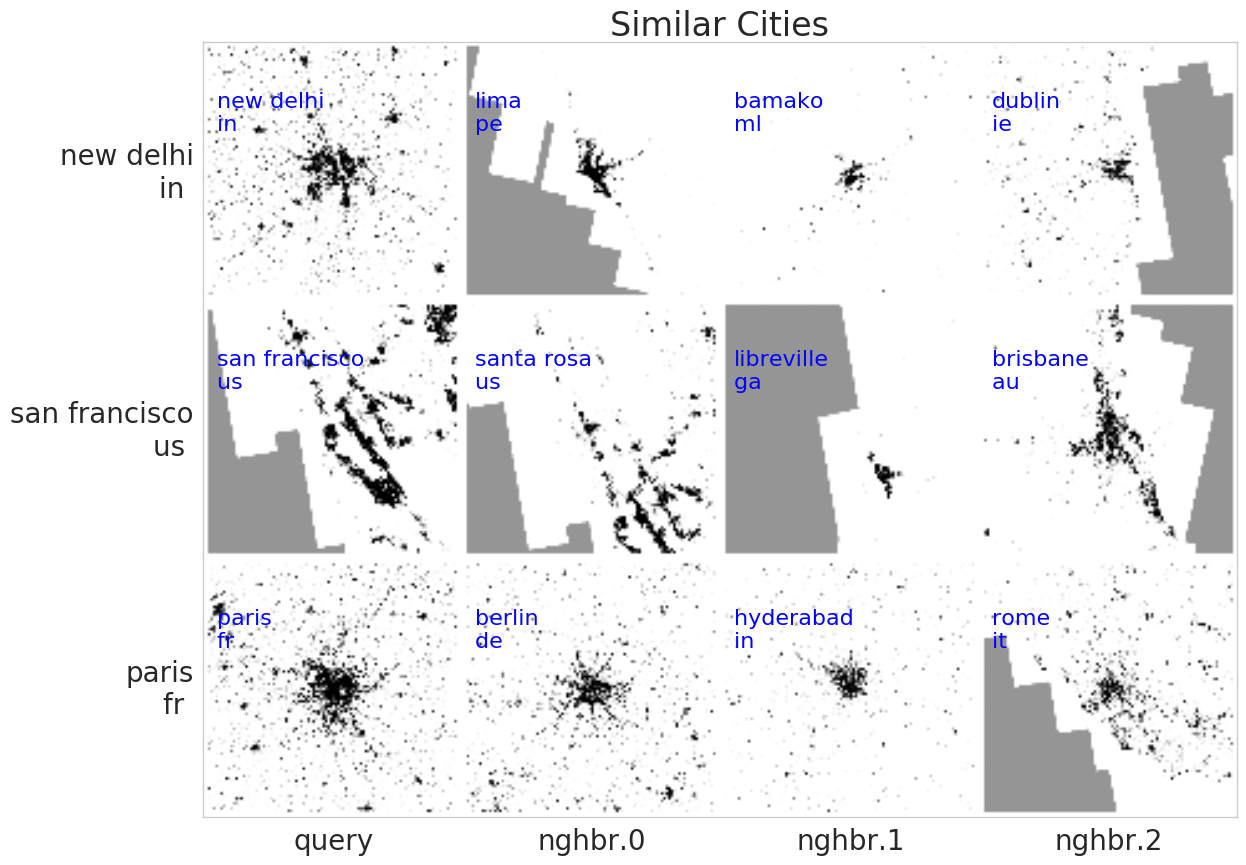

In [67]:
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1})

# plot
plt.figure(figsize=(20,10))
plt.imshow(canvass)
plt.yticks([])
plt.yticks([52 + i * 104 for i in range(len(sel_df))], [x.split("(")[0].replace(", ", "\n") for x in sel_df['city']])
plt.xticks([52 + i * 104 for i in range(n_examples)], ["query"] + ["nghbr.%d"%i for i in range(n_examples)])
plt.title("Similar Cities")

for i,(city0,f0,idx) in enumerate(zip(sel_df['city'], sel_df['filename'], neighbors)):
    for j,(_,r) in enumerate(test_df.ix[idx].iterrows()):
        city1 = r['city']
        plt.annotate(city1.split("(")[0].replace(", ", "\n"), 
                     xy=(5 + j * 104, 35 + i * 104), 
                     xytext=(5 + j * 104, 35 + i * 104),
                     fontsize=16, color="blue")

# Search similar images: simulations

In [55]:
tree_fake = KDTree(features_fake)

In [74]:
mycities = ["san francisco, us", "paris, fr", "delhi, in", 
            "lagos, ng", "bucharest, ro", "rome, it"]
sel_df = test_df[test_df['city'].apply(lambda s: sum([x in s for x in mycities])>0)]
feats_sel = features[sel_df.index,:]

# feats_sel = features_fake[idx_14,:]
# feats_sel = feats_sel[np.random.choice(range(len(feats_sel)), 5, replace=False),:]

n_examples = 5
_, neighbors = tree_fake.query(feats_sel, k=n_examples, breadth_first=True)

In [75]:
# create canvass
canvass = []
for city0,f0,idx in zip(sel_df['city'], sel_df['filename'], neighbors):
    img0 = imread(f0)
    row = []
    row = [np.pad(resize(img0, (100,100)), (2,2), "constant")]
    for img in img_fake[idx,:]:
        row.append(np.pad(resize(img, (100,100)), (2,2), "constant"))
    canvass.append(np.hstack(row))
canvass = np.vstack(canvass)

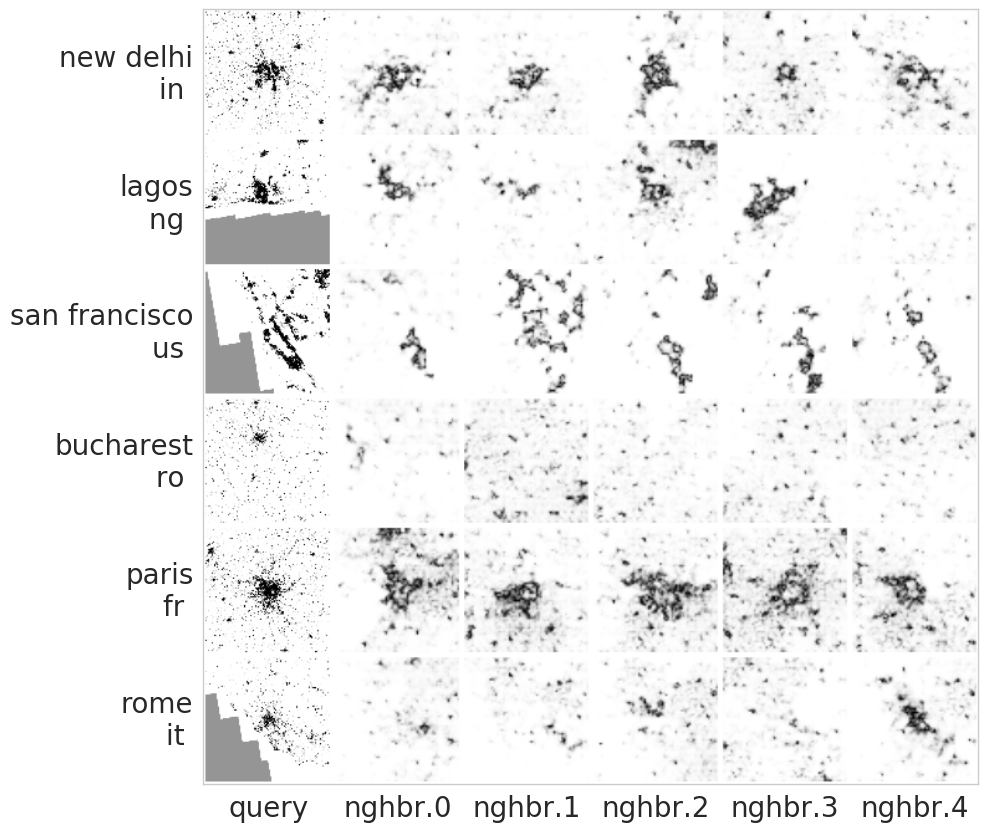

In [78]:
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 1})

# plot
plt.figure(figsize=(20,10))
plt.imshow(canvass)
plt.yticks([])
plt.yticks([52 + i * 104 for i in range(len(sel_df))], \
             [x.split("(")[0].replace(", ", "\n") for x in sel_df['city']])
plt.xticks([52 + i * 104 for i in range(n_examples+1)], \
           ["query"] + ["nghbr.%d"%i for i in range(n_examples)])
# plt.title("Simulations similar to real cities")
plt.show()

# Clustering test samples

In [ ]:
from sklearn.cluster import KMeans

feats_reduced = feats_tsne #feats_pca

loss_vec = []
k_vec = np.linspace(5, 100, 40)
for k in k_vec:
    print int(k),
    kmeans = KMeans(n_clusters=int(k), random_state=0).fit(feats_reduced)
    loss = -kmeans.score(feats_reduced)
    loss_vec.append(loss)

In [ ]:
plt.figure(figsize=(4,4))
plt.plot(k_vec, np.array(loss_vec)/1e6)
plt.title("K-Means loss vs # clusters")
plt.xlabel("# Clusters")
plt.ylabel("loss (/1e6)")

In [ ]:
K_opt = 25
kmeans = KMeans(n_clusters=K_opt, random_state=0).fit(feats_tsne)

C = kmeans.predict(feats_tsne)

In [ ]:
(pd.Series(C).value_counts() / float(len(C))).plot(kind="barh", figsize=(4,4))
plt.title("Cluster Membership Distribution")
plt.xlabel("pct membership")
plt.ylabel("cluster ID")

In [ ]:
def plot_examples(image_paths, labels, classes=None, \
                  nExamples=10, thumbSize = (64,64), pad_pix=2, title="example"):
    # build example canvass 
    from skimage.transform import resize
    from skimage.io import imread
    
    clustLabels = np.unique(labels)
    nClusters = clustLabels.size
    canvas = np.ones(((thumbSize[0]+pad_pix)*nClusters, nExamples*(thumbSize[1]+pad_pix)))
    for i,c in enumerate(clustLabels):
        cur_class_samples = np.where(labels==c)[0]
        idx = np.random.choice(cur_class_samples, replace=False, size=min([nExamples, len(cur_class_samples)]))
        for j in range(len(idx)):
            img = imread(image_paths[idx[j]])
            img = img / float(img.max())
            img[abs(img-0.5)<0.01] = 0 # hack to remove no-data patches
            # img = 1-img
            img = resize(img, thumbSize)
            canvas[i*(thumbSize[0]+pad_pix):(i*pad_pix + (i+1)*thumbSize[0]), 
                   j*(thumbSize[1]+pad_pix):(j*pad_pix + (j+1)*thumbSize[1])] = img
    
    # plot examples of each class
    fig,ax = plt.subplots(1, figsize=(12,10))
    plt.tight_layout()
    print canvas.shape
    ax.imshow(canvas.swapaxes(0,1))#, aspect='auto')
    ax.set_title(title, fontsize=18)
    ax.set_ylabel("-- examples --", fontsize=16)
    ax.set_xlabel("-- land classes --", fontsize=16)
    # Turn off tick labels
    if classes is None: classes = clustLabels
    ax.set_xticks([thumbSize[0]*(0.5 + x) for x in range(nClusters)])
    ax.set_xticklabels(classes, fontsize=16, rotation=90)
    ax.set_yticklabels([])
    #plt.axis("off")
    plt.show()

In [ ]:
plot_examples(test_df['filename'].values, C)

# Visualize clusters
- linear grid assignment visualization

#### Standard t-SNE point clouds labeled for the clusters identified by K-Means

In [ ]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

def labeled_scatterplot(x, labels, palette=None, ax=None, add_text=True, alpha=None, figsize=None):
    
    classes = np.unique(labels)
    class_dict = {c:i for i,c in enumerate(classes)}
    n_clust = len(classes)    
    colors = [palette[l] for l in labels]

    # We create a scatter plot.
    if ax is None:
        f = plt.figure(figsize=figsize)
        ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=colors, alpha=alpha)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    if add_text:
        # We add the labels for each class.
        txts = []
        for k,c in enumerate(classes):
            # Position of each label.
            xtext, ytext = np.median(x[labels == c, :], axis=0)
            txt = ax.text(xtext, ytext, str(c), fontsize=24)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground=palette[c]),
                PathEffects.Normal()])
            txts.append(txt)

    return ax

In [ ]:
tsne = TSNE(n_jobs=32, perplexity=30, n_components=2)
feats_tsne_2d = tsne.fit_transform(features.astype(np.float64))

In [ ]:
sns.palplot(sns.color_palette("hls", K_opt))

In [ ]:
import matplotlib
palette = dict(zip(range(K_opt), sns.color_palette("hls", K_opt)))
labeled_scatterplot(feats_tsne_2d, C, palette=palette, ax=None, \
                    add_text=True, figsize=None)

#### Stretch point cloud to uniform grid

In [ ]:
from scipy.spatial.distance import cdist

size = 50

grid = np.dstack(np.meshgrid(np.linspace(0, 1, size), np.linspace(0, 1, size))).reshape(-1, 2)

idx = np.random.choice(range(len(feats_tsne_2d)), size*size, replace=False)
cost_matrix = cdist(grid, feats_tsne_2d[idx,:], "sqeuclidean").astype(np.float32)
cost_matrix = cost_matrix * (100000 / cost_matrix.max())

In [ ]:
import lapjv

_, row_asses, col_asses = lapjv.lapjv(cost_matrix)

In [ ]:
grid_jv = grid[row_asses]
pp_cmap = matplotlib.colors.ListedColormap(palette.values())
for start, end, t in zip(feats_tsne_2d[idx,:], grid_jv, C[idx]):
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
          head_length=0.005, head_width=0.005, color=pp_cmap(t), alpha=0.5)
#colorbar(my_colorbar.mappable, fraction=0.05, pad = 0.0125)
plt.xticks([]); plt.yticks([])

# Clustering analysis 

In [ ]:
test_df.head()

In [ ]:
regions_df = pd.read_csv("/home/adalbert/data/countries_regions.csv")

country2region = {r:c for r,c in zip(regions_df['alpha-2'].str.lower(), regions_df['region'])}

test_df['region'] = test_df['country'].apply(lambda x: country2region[x] if x in country2region else np.nan)

print "Could not map to regions %d out of %d cities."%(test_df['region'].isnull().sum(), len(test_df))

In [ ]:
df = test_df[["filename", 'region', 'decile', 'built pct', 'class']]
df['cluster'] = C

In [ ]:
df.head()

In [ ]:
df.groupby("region").apply(lambda x: x['cluster'].value_counts() / float(len(x))).unstack()\
    .plot(kind="bar", stacked=True, figsize=(6,4), cmap=pp_cmap)
plt.legend(bbox_to_anchor=(1.2, 1.15), fontsize=12)
plt.title("World-wide distribution of city types", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

In [ ]:
df.head()

In [ ]:
df.head()

In [ ]:
stats = df.groupby(["cluster"]).apply(lambda x: (x['built pct'].mean().round(3), 
                                         x['built pct'].std().round(3)))

In [ ]:
df.boxplot(column="built pct", by="cluster")

In [ ]:
df.groupby("cluster").apply(len).plot(kind="bar")

In [ ]:
idx = df['cluster']==0
plot_examples(df[idx]['filename'].values, 
              df[idx]['region'].values, nExamples=4) 